In [44]:
import wrds
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import scipy as sp

In [3]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [45]:
sp500_tickers = []
with open('sp500.txt', 'r') as f:
    for line in f:
        sp500_tickers.append(line.strip())
sp500_tickers[:5]

['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL']

In [6]:
ibes_tickers = []
for t in tqdm(sp500_tickers):
    try:
        data = conn.raw_sql(f"""SELECT ticker, oftic, cname, estimator, analys, FPI, MEASURE, VALUE, FPEDATS, ANNDATS, ANNTIMS, ACTUAL, ANNDATS_ACT, ANNTIMS_ACT
                         FROM tr_ibes.det_epsus
                         WHERE oftic = '{t}'
                         and anndats >= '01/01/2024'
                         and fpi = '6'
                         """)
        if data.shape[0] == 0:
            print(f"No data for {t}")
        else:
            ibes_ticker = data['ticker'].iloc[0]
            ibes_tickers.append((t, ibes_ticker))
        # print(t, data.shape)
    except Exception as e:
        print(f"Error for {t}: {e}")

 76%|███████▌  | 381/501 [00:18<00:05, 22.90it/s]

No data for VRSN


 78%|███████▊  | 393/501 [00:19<00:04, 22.09it/s]

No data for L


 83%|████████▎ | 414/501 [00:19<00:03, 24.16it/s]

No data for NWS


100%|██████████| 501/501 [00:23<00:00, 21.23it/s]

No data for AMTM


In [17]:
for oftic, ibes in tqdm(ibes_tickers):
    data = conn.raw_sql(f"""SELECT ticker, oftic, cname, estimator, analys, FPI, MEASURE, VALUE, FPEDATS, ANNDATS, ANNTIMS, ACTUAL, ANNDATS_ACT, ANNTIMS_ACT
                         FROM tr_ibes.det_epsus
                         WHERE ticker = '{ibes}'
                         and anndats >= '01/01/2020'
                         and fpi = '6'
                         """)
    data.to_csv(f"data/ibes/{oftic}.csv", index=False)

100%|██████████| 497/497 [00:29<00:00, 16.78it/s]


In [ ]:
with open('ibes_tickers.pkl', 'wb') as f:
    pickle.dump(ibes_tickers, f)

In [2]:
with open('ibes_tickers.pkl', 'rb') as f:
    ibes_tickers = pickle.load(f)
    
ibes_data = dict()
for oftic, ibes in tqdm(ibes_tickers):
    data = pd.read_csv(f"data/ibes/{oftic}.csv")
    ibes_data[oftic] = data

100%|██████████| 497/497 [00:00<00:00, 947.40it/s] 


In [46]:
ibes_data['AAPL'].head()

,ticker,oftic,cname,estimator,analys,fpi,measure,value,fpedats,anndats,anntims,actual,anndats_act,anntims_act
0,AAPL,AAPL,APPLE,1267.0,193808.0,6,EPS,1.1500,2019-12-31,2020-01-03,00:49:00,1.2475,2020-01-28,16:30:00
1,AAPL,AAPL,APPLE,3374.0,110208.0,6,EPS,1.1775,2019-12-31,2020-01-05,12:10:00,1.2475,2020-01-28,16:30:00
2,AAPL,AAPL,APPLE,930.0,191412.0,6,EPS,1.1775,2019-12-31,2020-01-09,07:00:00,1.2475,2020-01-28,16:30:00
3,AAPL,AAPL,APPLE,2301.0,83036.0,6,EPS,1.1450,2019-12-31,2020-01-09,13:00:00,1.2475,2020-01-28,16:30:00
4,AAPL,AAPL,APPLE,79.0,108299.0,6,EPS,1.1175,2019-12-31,2020-01-13,06:34:00,1.2475,2020-01-28,16:30:00


In [6]:
ibes_data['AAPL']['anndats_act'].dropna().unique()

array(['2020-01-28', '2020-04-30', '2020-07-30', '2020-10-29',
       '2021-01-27', '2021-04-28', '2021-07-27', '2021-10-28',
       '2022-01-27', '2022-04-28', '2022-07-28', '2022-10-27',
       '2023-02-02', '2023-05-04', '2023-08-03', '2023-11-02',
       '2024-02-01', '2024-05-02', '2024-08-01', '2024-10-31'],
      dtype=object)

In [7]:
ibes_data['NVDA']['anndats_act'].dropna().unique()

array(['2020-02-13', '2020-05-21', '2020-08-19', '2020-11-18',
       '2021-02-24', '2021-05-26', '2021-08-18', '2021-11-17',
       '2022-02-16', '2022-05-25', '2022-08-24', '2022-11-16',
       '2023-02-22', '2023-05-24', '2023-08-23', '2023-11-21',
       '2024-02-21', '2024-05-22', '2024-08-28'], dtype=object)

In [161]:
for t, data in ibes_data.items():
    data = data.dropna()
    if data['anndats_act'].unique().shape[0] != 20:
        print(t, data['anndats_act'].unique().shape)

NVDA (19,)
AVGO (19,)
WMT (19,)
ORCL (19,)
COST (19,)
CRM (18,)
CSCO (19,)
ACN (19,)
ABT (19,)
ADBE (19,)
PLTR (17,)
INTU (19,)
QCOM (19,)
ANET (19,)
LOW (19,)
TJX (19,)
PANW (19,)
DE (19,)
NKE (19,)
ADI (18,)
MDT (19,)
MU (19,)
PLD (19,)
GEV (3,)
CRWD (19,)
APH (19,)
ABNB (16,)
DELL (19,)
MSI (19,)
SNPS (18,)
CTAS (19,)
CEG (11,)
FDX (19,)
ADSK (19,)
CARR (19,)
TGT (19,)
CPRT (19,)
AZO (19,)
PSA (19,)
PAYX (19,)
ROST (19,)
AXON (19,)
LULU (19,)
O (19,)
KR (19,)
KDP (19,)
KVUE (5,)
A (19,)
SYY (19,)
OTIS (19,)
LEN (19,)
IR (19,)
GEHC (7,)
GIS (19,)
CCL (19,)
IDXX (19,)
HPQ (19,)
ANSS (19,)
CSGP (19,)
MPWR (19,)
GDDY (19,)
HPE (19,)
KEYS (18,)
EQR (19,)
SW (2,)
TPL (19,)
TYL (19,)
VLTO (4,)
NVR (19,)
NTAP (19,)
WST (19,)
HUBB (19,)
ROL (19,)
PTC (19,)
DRI (19,)
IFF (19,)
ERIE (19,)
TDY (19,)
ATO (19,)
STE (19,)
ZBRA (19,)
ULTA (19,)
BF.B (19,)
LDOS (19,)
PODD (19,)
COO (19,)
SMCI (19,)
MAA (19,)
FDS (19,)
BBY (19,)
SNA (19,)
HRL (19,)
J (19,)
DG (19,)
NWSA (19,)
UDR (19,)
JBL (19,)
IEX 

In [ ]:
for t, data in ibes_data.items():
    first_fpedats = pd.to_datetime(data['fpedats'].iloc[0], format='%Y-%m-%d')
    if first_fpedats > pd.to_datetime('2020-02-01'):
        print(t, first_fpedats)

ORCL 2020-02-29 00:00:00
COST 2020-02-29 00:00:00
CRM 2020-04-30 00:00:00
CSCO 2020-04-30 00:00:00
ACN 2020-02-29 00:00:00
ABT 2020-03-31 00:00:00
ADBE 2020-02-29 00:00:00
PLTR 2020-09-30 00:00:00
QCOM 2020-03-31 00:00:00
ANET 2020-03-31 00:00:00
LOW 2024-10-31 00:00:00
NKE 2020-02-29 00:00:00
ADI 2020-04-30 00:00:00
MU 2020-02-29 00:00:00
PLD 2020-03-31 00:00:00
GEV 2024-03-31 00:00:00
APH 2020-03-31 00:00:00
ABNB 2020-12-31 00:00:00
MSI 2020-03-31 00:00:00
SNPS 2020-04-30 00:00:00
CTAS 2020-02-29 00:00:00
CEG 2022-03-31 00:00:00
FDX 2024-11-30 00:00:00
CARR 2020-03-31 00:00:00
AZO 2020-02-29 00:00:00
JCI 2024-12-31 00:00:00
PSA 2020-03-31 00:00:00
PAYX 2020-02-29 00:00:00
AXON 2020-03-31 00:00:00
O 2020-03-31 00:00:00
DHI 2024-12-31 00:00:00
KDP 2020-03-31 00:00:00
KVUE 2023-03-31 00:00:00
SYY 2020-03-31 00:00:00
OTIS 2020-03-31 00:00:00
LEN 2020-02-29 00:00:00
GEHC 2023-03-31 00:00:00
GIS 2020-02-29 00:00:00
CCL 2020-02-29 00:00:00
IDXX 2020-03-31 00:00:00
ANSS 2020-03-31 00:00:00
C

There are a lot of date mismatches. What we really should do is align dates to match dates as close together as possible. This is a multidimensional assignment problem (MAP) (which is NP-Hard). However, we still need to solve it for this dataset. So, we will use the `kap` library, which implements some algos for MAP problems.

This was a valiant effort, but takes too long for our purposes. We know the start and end date have 5 years and 4 quarters per year. Thus, we know there are 20 quarters in total to fit everything into. Thus, our problem is far more structured than a general MAP problem. We can use this to our advantage and solve the problem in a more efficient manner.

We will simply solve a linear assignment problem to match each date to some "base" point. Our "base" point will be Apple since it has 20 unique dates in this dataset.

In [5]:
unique_dates = dict()
max_length = 20
for t, data in ibes_data.items():
    dates = pd.to_datetime(data['anndats_act'].dropna().unique(), format='%Y-%m-%d')
    dates = np.array(list(dates) + [pd.NaT] * (max_length - len(dates)))
    unique_dates[t] = dates

In [3]:
from itertools import combinations
from scipy.optimize import linear_sum_assignment

In [6]:
cost_matrices = [] # cost matrix for 'AAPL' to all other tickers

base_date = unique_dates['AAPL']

aligned_dates = dict()

for t, d in unique_dates.items():
    cost_matrix = []
    for d1 in base_date:
        row = []
        for d2 in d:
            row.append(abs((d1 - d2).days) if pd.notna(d1) and pd.notna(d2) else 365*5*2)
        cost_matrix.append(row)
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=False)
    aligned_dates[t] = d[col_ind]

In [7]:
aligned_dates['CRM']

array([NaT, Timestamp('2020-05-28 00:00:00'),
       Timestamp('2020-08-25 00:00:00'), Timestamp('2020-12-01 00:00:00'),
       Timestamp('2021-02-25 00:00:00'), Timestamp('2021-05-27 00:00:00'),
       Timestamp('2021-08-25 00:00:00'), Timestamp('2021-11-30 00:00:00'),
       Timestamp('2022-03-01 00:00:00'), Timestamp('2022-05-31 00:00:00'),
       Timestamp('2022-08-24 00:00:00'), Timestamp('2022-11-30 00:00:00'),
       Timestamp('2023-03-01 00:00:00'), Timestamp('2023-05-31 00:00:00'),
       Timestamp('2023-08-30 00:00:00'), Timestamp('2023-11-29 00:00:00'),
       Timestamp('2024-02-28 00:00:00'), Timestamp('2024-05-29 00:00:00'),
       Timestamp('2024-08-28 00:00:00'), NaT], dtype=object)

We now have aligned dates. We can use this to properly construct our tabular dataset.

Now, we need to start groupping the data by quarter. We can initially do this by grouping the data by the announce date of the actual EPS.

In [49]:
# since we start at January 1, 2020, we can assume that the first date is the first quarter of 2020
quarterly_data = dict()
quarterly_actual = dict() # actual value, announcement date, announcement time
quarterly_means = dict()
for oftic, data in tqdm(ibes_data.items()):
    data = data.dropna(axis=0, subset=['anndats_act'])
    starting_year = 2020 # we start at January 1, 2020
    for i, date in enumerate(aligned_dates[oftic]):
        quarter_num = (i % 4) + 1 # 1,2,3,4
        year = starting_year + (i // 4)
        if date is pd.NaT:
            quarterly_actual[oftic, year, quarter_num] = None
            quarterly_data[oftic, year, quarter_num] = None
            continue
        date = date.strftime('%Y-%m-%d')
        subdata = data[data['anndats_act'] == date].copy()
        
        quarterly_actual[oftic, year, quarter_num] = (subdata['actual'].iloc[0], 
                                                      subdata['anndats_act'].iloc[0],
                                                      subdata['anntims_act'].iloc[0])
        subdata['ann_datetime'] = pd.to_datetime(subdata['anndats'] + ' ' + subdata['anntims'], format='%Y-%m-%d %H:%M:%S')
        
        # Align to have the same means
        mean_value = subdata['value'].mean()
        subdata['value'] = subdata['value'] - mean_value
        quarterly_means[oftic, year, quarter_num] = mean_value
        
        quarterly_data[oftic, year, quarter_num] = subdata[['value', 'ann_datetime']]

100%|██████████| 497/497 [00:05<00:00, 91.84it/s]


In [50]:
quarterly_data['AAPL', 2020, 1].head()

,value,ann_datetime
0,0.0000,2020-01-03 00:49:00
1,0.0275,2020-01-05 12:10:00
2,0.0275,2020-01-09 07:00:00
3,-0.0050,2020-01-09 13:00:00
4,-0.0325,2020-01-13 06:34:00


In [48]:
with open('quarterly_actual.pkl', 'wb') as f:
    pickle.dump(quarterly_actual, f)

with open('quarterly_data.pkl', 'wb') as f:
    pickle.dump(quarterly_data, f)

In [8]:
with open('quarterly_actual.pkl', 'rb') as f:
    quarterly_actual = pickle.load(f)
    
with open('quarterly_data.pkl', 'rb') as f:
    quarterly_data = pickle.load(f)

We have 5 years: 2020, 2021, 2022, 2023, and 2024.

We have 4 quarters in a year: Q1, Q2, Q3, and Q4.

Thus, we have 20 columns (year/quarter) to work with and 497 rows (companies)

In [9]:
# Use step function helper functions since we have different sample amounts.
from itertools import combinations
import bisect

def step_function(x_points, y_points, x):
    # Find the interval that x falls into
    idx = bisect.bisect_right(x_points, x) - 1
    # If x is before the first point, return the first y
    if idx < 0:
        return y_points[0]
    # If x is beyond the last point, return the last y
    elif idx >= len(y_points):
        return y_points[-1]
    # Otherwise, return the y corresponding to the interval
    return y_points[idx]

def squared_difference_integral(x1, y1, x2, y2):
    # Combine and sort all x points from both arrays, ensuring no duplicates
    x_points = np.unique(np.concatenate((x1, x2)))
    total_integral = 0.0

    for i in range(len(x_points) - 1):
        # Define the interval [x_points[i], x_points[i+1]]
        x_left = x_points[i]
        x_right = x_points[i + 1]
        interval_length = x_right - x_left

        # Find the y-values for this interval
        # Last y-value from each array that is <= x_left
        y1_value = step_function(x1, y1, x_left)
        y2_value = step_function(x2, y2, x_left)

        # Compute squared difference and add to total integral
        squared_difference = (y1_value - y2_value) ** 2
        total_integral += squared_difference * interval_length

    return total_integral

def average_step_function(step_functions):
    # Extract x and y values from each step function
    all_x = np.unique(np.concatenate([sf[0] for sf in step_functions]))
    avg_y = []

    # Loop through each interval
    for i in range(len(all_x) - 1):
        x_left = all_x[i]
        
        # For each step function, get the y-value at the start of this interval
        y_values = []
        for x, y in step_functions:
            y_val = step_function(x, y, x_left)
            y_values.append(y_val)
        # Compute the average y-value for this interval
        avg_y.append(np.mean(y_values))

    # Add the final y-value after the last x-point
    y_values = [y[np.searchsorted(x, all_x[-1], side='right') - 1] for x, y in step_functions]
    avg_y.append(np.mean(y_values))

    return all_x, np.array(avg_y)

def get_wasserstein_dists(ppf_dict, direction = 'user'):
    """Return the pairwise Wasserstein distance for the given row (plaza_id, weekday)
    to all the other rows.

    Args:
        plaza_id (int): ID of bridge or tunnel
        weekday (int): Day of the week (1-7)
        ppf_dict (dict): Dictionary of inverse CDFs

    Returns:
        dict: Dictionary of pairwise Wasserstein distances
    """
    rows = set(k[0] for k in ppf_dict.keys())
    cols = set(k[1] for k in ppf_dict.keys())
    dists = dict()
    
    if direction == 'user':
        row_pairs = list(combinations(rows, 2))
        
        for key1, key2 in tqdm(row_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for c in cols:
                key_row1 = (key1, c)
                key_row2 = (key2, c)
                if ppf_dict.get(key_row1) is None or ppf_dict.get(key_row2) is None:
                    dists[key][c] = None
                    continue
                # dists[key][c] = wasserstein2_mc(ppf_dict[key_row1], ppf_dict[key_row2])
                x1,y1 = ppf_dict[key_row1]
                x2,y2 = ppf_dict[key_row2]
                dists[key][c] = squared_difference_integral(x1, y1, x2, y2)
    elif direction == 'item':
        col_pairs = list(combinations(cols, 2))
        
        for key1, key2 in tqdm(col_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for r in rows:
                key_col1 = (r, key1)
                key_col2 = (r, key2)
                if ppf_dict.get(key_col1) is None or ppf_dict.get(key_col2) is None:
                    dists[key][r] = None
                    continue
                # dists[key][r] = wasserstein2_mc(ppf_dict[key_col1], ppf_dict[key_col2])
                x1,y1 = ppf_dict[key_col1]
                x2,y2 = ppf_dict[key_col2]
                dists[key][r] = squared_difference_integral(x1, y1, x2, y2)
    return dists

In [51]:
def wasserstein2(sample1, sample2):
    """Compute the squared 2-Wasserstein distance between two samples.
    Inputs need to be in format (sample, dimension).
    Args:
        sample1 (np.array): 2D array of samples from the first distribution
        sample2 (np.array): 2D array of samples from the second distribution
    """
    C = ot.dist(sample1, sample2, metric='sqeuclidean')
    # Uniform weights for each empirical distribution
    a = np.ones(len(sample1)) / len(sample1)
    b = np.ones(len(sample2)) / len(sample2)

    # Compute optimal transport plan and Wasserstein distance
    P = ot.emd(a, b, C)
    return np.sum(P * C)

wasserstein2(np.array([1,2,3]).reshape(-1,1), np.array([1,2,1]).reshape(-1,1))

np.float64(0.6666666666666666)

In [11]:
def wass_barycenter(sample_list):
    """Compute the Wasserstein barycenter from a list of sample arrays.
    Returns the x,y coordinates for the quantile function of the barycenter.
    """
    step_functions = list()
    for sample_arr in sample_list:
        x = np.cumsum(np.ones(len(sample_arr)) / len(sample_arr))
        y = np.sort(sample_arr)
        step_functions.append((x, y))
    x_avg, y_avg = average_step_function(step_functions)
    return (x_avg, y_avg)

In [12]:
# How will we compute the Wasserstein distance between the barycenter and samples?
# We will have to use the step function representation for the samples because
# converting an arbitrary distribution to a sample can take a lot of memory.

def wass_barycenter_dist(sample_arr, barycenter):
    """Compute the Wasserstein distance between the barycenter and an array of samples.
    """
    x = np.cumsum(np.ones(len(sample_arr)) / len(sample_arr))
    y = np.sort(sample_arr)
    return squared_difference_integral(barycenter[0], barycenter[1], x, y)

In [57]:
# There are a lot of rows, so we will estimate distances for specific rows.
# We will need to make sure that we do not look into the future.
# When calculating distances, we will only look at the past data, using the 
# datestimes when the actual EPS are announced, since we would like to estimate our distributions
# as late as possible (close to the announcement date).

def get_rows_cols():
    cols = [(year, quarter) for year in range(2020, 2025) for quarter in range(1, 5)]
    rows = list(ibes_data.keys())
    return rows, cols

def get_dist(ticker, year, quarter, quarterly_actual, quarterly_data):
    # Returns the squared Wasserstein distance between rows for 1 column
    # Filters to only use past data
    rows, _ = get_rows_cols()
    
    actual = quarterly_actual[ticker, year, quarter]
    actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')
    sample1 = quarterly_data[ticker, year, quarter]['value'].values.reshape(-1,1)
    dists = dict()
    for row in rows:
        dist = 0
        raw_data = quarterly_data[row, year, quarter]
        if raw_data is None:
            dists[row] = np.nan
            continue
        # only past data
        filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
        if filtered_data.shape[0] == 0:
            dists[row] = np.nan
            continue
        sample2 = filtered_data['value'].values.reshape(-1,1)
        dist = wasserstein2(sample1, sample2)
        dists[row] = dist
    return dists

dists = get_dist('AAPL', 2020, 1, quarterly_actual, quarterly_data)

In [52]:
data = quarterly_data['AAPL', 2020, 2]
actual = quarterly_actual['AAPL', 2020, 2][0]
print(data, actual)

       value        ann_datetime
11  0.081164 2020-01-28 20:55:00
12  0.109164 2020-01-28 19:51:00
13  0.081664 2020-01-28 21:10:00
14  0.119164 2020-01-28 22:40:00
15  0.104164 2020-01-28 23:29:00
..       ...                 ...
92 -0.085836 2020-04-17 01:30:00
93 -0.083336 2020-04-20 06:20:00
94 -0.105836 2020-04-23 22:49:00
95 -0.177836 2020-04-24 08:00:00
96 -0.270836 2020-04-27 00:10:00

[86 rows x 2 columns] 0.6375


In [53]:
data['value'].mean(), data['value'].median(), data['value'].min(), data['value'].max()

(np.float64(5.034732320974547e-17),
 np.float64(0.006663953488372176),
 np.float64(-0.27083604651162785),
 np.float64(0.12666395348837212))

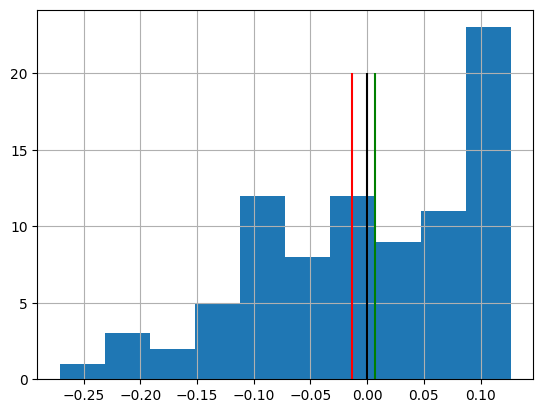

In [55]:
data['value'].hist()
plt.vlines(actual - quarterly_means['AAPL', 2020, 2], 0, 20, color='red')
plt.vlines(data['value'].mean(), 0, 20, color='black')
plt.vlines(data['value'].median(), 0, 20, color='green')

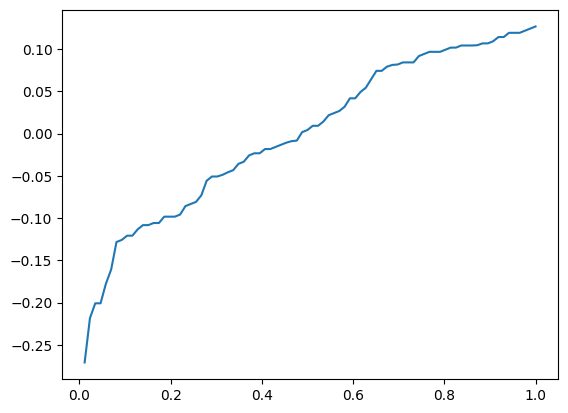

In [56]:
y = np.sort(data['value'].values)
x = np.cumsum(np.ones(len(y)) / len(y))
plt.plot(x, y)

In [64]:
threshold = 0.00005

neighbors = [ticker for ticker, dist in dists.items() if dist < threshold]
neighbors

['AAPL',
 'PG',
 'BAC',
 'T',
 'KMI',
 'AEP',
 'LVS',
 'FITB',
 'HAL',
 'CBOE',
 'BALL',
 'MKTX']

In [65]:
actual = quarterly_actual['AAPL', 2020, 2]
actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')

sample_list = []
for ticker in neighbors:
    raw_data = quarterly_data[ticker, 2020, 2]
    filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
    print(ticker, filtered_data.shape, raw_data.shape)
    sample_list.append(filtered_data['value'].values)

AAPL (86, 2) (86, 2)
PG (39, 2) (39, 2)
BAC (49, 2) (49, 2)
T (28, 2) (28, 2)
KMI (29, 2) (29, 2)
AEP (20, 2) (21, 2)
LVS (27, 2) (27, 2)
FITB (46, 2) (46, 2)
HAL (50, 2) (50, 2)
CBOE (37, 2) (37, 2)
BALL (15, 2) (15, 2)
MKTX (36, 2) (36, 2)


In [66]:
barycenter = wass_barycenter(sample_list)

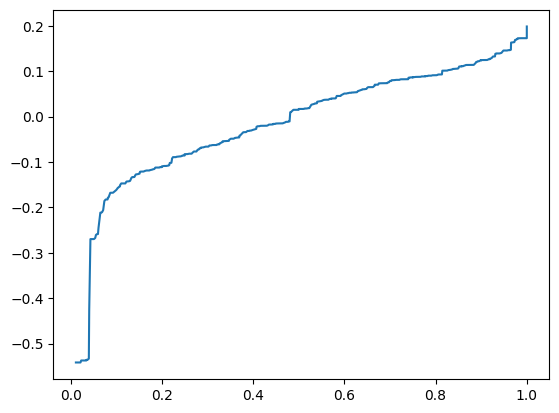

In [67]:
x,y = barycenter
plt.plot(x,y)

In [68]:
dists

{'AAPL': np.float64(0.0),
 'NVDA': np.float64(0.0003571963636363647),
 'MSFT': np.float64(0.0003136363636363638),
 'AMZN': np.float64(0.004519681594949492),
 'GOOGL': np.float64(0.0005447801704545468),
 'GOOG': np.float64(0.0007981783812615987),
 'META': np.float64(0.02365459636363634),
 'TSLA': np.float64(0.0005739137373737369),
 'AVGO': np.float64(0.0008536363636363616),
 'BRK.B': np.float64(0.0003136363636363638),
 'WMT': np.float64(0.00031693198493813876),
 'LLY': np.float64(0.0002340909090909098),
 'JPM': np.float64(0.0017067374932759538),
 'V': np.float64(7.942975206611567e-05),
 'MA': np.float64(5.863636363636272e-05),
 'ORCL': np.float64(0.0005190808080808088),
 'XOM': np.float64(0.003802393939393937),
 'UNH': np.float64(0.0020365454545454606),
 'COST': np.float64(0.0010524067717996271),
 'PG': np.float64(4.590909090909137e-05),
 'HD': np.float64(0.0002303998144712489),
 'NFLX': np.float64(0.003445363636363635),
 'JNJ': np.float64(0.0001015227272727275),
 'BAC': np.float64(4.31

In [14]:
def expectation(barycenter):
    # This is just the integral from 0 to 1 of the quantile function
    x,y = barycenter
    x_diff = np.concatenate([np.array(x[0]).reshape(1), np.diff(x)])
    return np.sum(x_diff * y)

In [74]:
threshold = 0.001

year = 2020
quarter = 2
ticker = 'AAPL'
dists = get_dist(ticker, year, quarter, quarterly_actual, quarterly_data)
neighbors = [t for t, dist in dists.items() if dist <= threshold]
print(len(neighbors))

actual = quarterly_actual[ticker, year, quarter]
actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')

sample_list = []
for t in neighbors:
    raw_data = quarterly_data[t, year, quarter]
    filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
    # print(t, filtered_data)
    # print(t, filtered_data.shape, raw_data.shape)
    sample_list.append(filtered_data['value'].values)

barycenter = wass_barycenter(sample_list)
print(quarterly_data[ticker, year, quarter]['value'].mean(), step_function(barycenter[0], barycenter[1], 0.5), expectation(barycenter))
print('Actual:',quarterly_actual[ticker, year, quarter][0] - quarterly_means[ticker, year, quarter])

33
5.034732320974547e-17 0.0010130010626904155 -0.0099764075837648
Actual: -0.013336046511627897


Hyperparamter tuning: We can tune the hyperparameter threshold with for the first 50% of the columns and use them to predict the last 50% of the columns. The target this time will not be reconstructing the original distribution, but rather predicting the actual quarter EPS.

In [198]:
from hyperopt import hp, fmin, tpe
from numpy import half

def evaluate_eta_column(eta, ticker, year, quarter, row_dists, quarterly_actual, quarterly_data, quarterly_means):
    """Return the squared error for estimating the actual EPS for the given eta and column.
    """
    neighbors = [t for t, dist in row_dists.items() if dist <= eta]
    if len(neighbors) == 0:
        # this should never happen because a ticker should always be a neighbor with itself
        raise Exception(f"No neighbors found for {ticker,year,quarter}")
    actual = quarterly_actual[ticker, year, quarter]
    if actual is None:
        return 0
    actual_datetime = pd.to_datetime(f'{actual[1]} {actual[2]}', format='%Y-%m-%d %H:%M:%S')
    actual_eps = actual[0] - quarterly_means[ticker, year, quarter]
    sample_list = []
    for t in neighbors:
        raw_data = quarterly_data[t, year, quarter]
        if raw_data is None: # it is possible that we have no data for a neighbor for this quarter
            continue
        filtered_data = raw_data[raw_data['ann_datetime'] < actual_datetime]
        # We don't have to worry about empty dataframes since we have already filtered
        # to only only use non-empty dataframes when calculating distances
        sample_list.append(filtered_data['value'].values)
    barycenter = wass_barycenter(sample_list)
    barycenter_expectation = expectation(barycenter)
    return (barycenter_expectation - actual_eps) ** 2

def optimize_eta(ticker, train_cols, quarterly_actual, quarterly_data, quarterly_means):
    # Get distances for each column in the training set
    row_dists = dict()
    for col in train_cols:
        if quarterly_actual.get((ticker, col[0], col[1])) is None:
            continue
        dists = get_dist(ticker, col[0], col[1], quarterly_actual, quarterly_data)
        row_dists[col] = dists
    
    # Define the objective function
    def obj(eta):
        # Loop through each column and calculate the squared error
        
        # We use the previous columns to determine the average row distance
        # We use the current column to determine the neighbors
        avg_distance = dict()
        total_error = 0
        for i in range(3, len(train_cols)):
            col = train_cols[i]
            all_dists = [row_dists[train_cols[j]] for j in range(i)]
            key_union = set()
            for j in range(i):
                key_union = key_union | row_dists[train_cols[j]].keys()
            avg_distance = dict()
            # Combine the keys
            for key in key_union:
                avg_distance[key] = np.mean([d[key] for d in all_dists if d.get(key) is not None])
            
            # Calculate the error for the column
            error = evaluate_eta_column(eta, ticker, col[0], col[1], avg_distance, 
                                        quarterly_actual, quarterly_data, quarterly_means)
            total_error += error
        return error
    
    # Optimize the objective function
    best_eta = fmin(fn=obj, verbose = True, space=hp.loguniform('eta', -10, -1), algo=tpe.suggest, max_evals=30)
    print(f"Baseline: {obj(0.0)}")
    return best_eta['eta']

_, cols = get_rows_cols()
ticker = 'MSFT'
eta = optimize_eta(ticker, cols[:len(cols) // 2], quarterly_actual, quarterly_data, quarterly_means)

100%|██████████| 30/30 [00:09<00:00,  3.27trial/s, best loss: 0.0006363413111342422]
Baseline: 0.0006363413111342422


In [199]:
def evaluate_eta_test(eta, ticker, train_cols, test_cols, quarterly_actual, quarterly_data, quarterly_means):
    """Return the squared error for estimating the actual EPS for the given eta and column.
    """
    # Get distances for each column in the test set
    row_dists = dict()
    for col in train_cols + test_cols:
        if quarterly_actual.get((ticker, col[0], col[1])) is None:
            continue
        dists = get_dist(ticker, col[0], col[1], quarterly_actual, quarterly_data)
        row_dists[col] = dists
    
    avg_distance = dict()
    total_error = 0
    for i in range(0, len(test_cols)):
        col = test_cols[i]
        # prepend by train columns
        all_dists = [row_dists[c] for c in train_cols] + [row_dists[test_cols[j]] for j in range(i)]
        key_union = set()
        for j in range(len(train_cols)):
            key_union = key_union | row_dists[train_cols[j]].keys()
        for j in range(i):
            key_union = key_union | row_dists[test_cols[j]].keys()
        avg_distance = dict()
        # Combine the keys
        for key in key_union:
            avg_distance[key] = np.mean([d[key] for d in all_dists if d.get(key) is not None])
        
        # Calculate the error for the column
        error = evaluate_eta_column(eta, ticker, col[0], col[1], avg_distance, 
                                    quarterly_actual, quarterly_data, quarterly_means)
        print(error)
        total_error += error
        return error

print(f'Eta: {eta}')
print('DistNN:', evaluate_eta_test(eta, ticker, cols[:len(cols) // 2], [cols[len(cols) // 2]], quarterly_actual, quarterly_data, quarterly_means))
print('Base:  ', evaluate_eta_test(0.0, ticker, cols[:len(cols) // 2], [cols[len(cols) // 2]], quarterly_actual, quarterly_data, quarterly_means))

Eta: 9.905039131459623e-05
0.007246265625000001
DistNN: 0.007246265625000001
0.007246265625000001
Base:   0.007246265625000001


In [160]:
quarterly_data['AAPL', 2022, 3]

,value,ann_datetime
387,-0.03473,2022-04-28 20:45:00
388,-0.09473,2022-04-28 23:22:00
389,-0.01073,2022-04-28 21:00:00
390,-0.09673,2022-04-28 22:50:00
391,-0.05473,2022-04-28 23:17:00
392,-0.03473,2022-04-28 22:57:00
393,-0.06473,2022-04-28 20:34:00
394,-0.02473,2022-04-28 21:58:00
395,-0.04473,2022-04-28 02:43:00
396,0.04527,2022-04-28 23:51:00


In [97]:
print('DistNN:', evaluate_eta_test(0.005, 'AAPL', cols[:len(cols) // 2], quarterly_actual, quarterly_data, quarterly_means))
print('Base:  ', evaluate_eta_test(0, 'AAPL', cols[:len(cols) // 2], quarterly_actual, quarterly_data, quarterly_means))

DistNN: 0.4499091494962601
Base:   0.41223900654266826


In [ ]:
i = 0
output_file = 'test_errors.csv'
train_cols = cols[:len(cols) // 2]
test_cols = cols[len(cols) // 2:]
for oftic in tqdm(list(ibes_data.keys())):
    try:
        eta = optimize_eta(oftic, train_cols, quarterly_actual, quarterly_data)
        test_error = evaluate_eta_test(eta, oftic, test_cols, quarterly_actual, quarterly_data)
        base_error = evaluate_eta_test(0, oftic, test_cols, quarterly_actual, quarterly_data)
        
        df = pd.DataFrame({'ticker': [oftic], 'eta': [eta], 'test_error': [test_error], 'base_error': [base_error]})
        if i == 0:
            # Write header only for the first row
            df.to_csv(output_file, mode='w', index=False)
        else:
            # Append to the file without writing the header
            df.to_csv(output_file, mode='a', index=False, header=False)
        i += 1
    except Exception as e:
        print(f"Error for {oftic}: {e}")

In [60]:
errors = pd.read_csv('test_errors.csv')

(array([ 11.,  44., 111., 149., 103.,  36.,  11.,   3.,   1.,   1.]),
 array([-7.23089387, -5.53016508, -3.82943628, -2.12870749, -0.4279787 ,
         1.2727501 ,  2.97347889,  4.67420768,  6.37493648,  8.07566527,
         9.77639406]),
 <BarContainer object of 10 artists>)

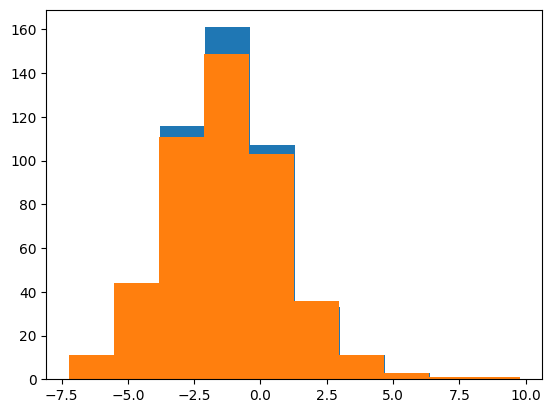

In [55]:
plt.hist(np.log(errors['test_error']))
plt.hist(np.log(errors['base_error']))

This is a bit unrealistic since there is so much time between quarters. What would really happen is that the parameters would be updated each timestep using a window (rolling or not rolling) approach.

We will try out a few approaches:
1. Growing window size
2. Rolling window
3. Seasonal window (only use the same quarter data)

In [20]:
# Growing window size

output_file = 'growing_window.csv'
cols = get_rows_cols()[1]

for j in range(1, len(cols) - 1):
    train_cols = cols[:j]
    test_col = cols[j]
    print(train_cols, test_col)
    i = 0
    year, quarter = test_col
    for oftic in tqdm(list(ibes_data.keys())):
        # try:
        eta = optimize_eta(oftic, train_cols, quarterly_actual, quarterly_data)
        test_error = evaluate_eta_test(eta, oftic, [test_col], quarterly_actual, quarterly_data)
        base_error = evaluate_eta_test(0, oftic, [test_col], quarterly_actual, quarterly_data)
        
        df = pd.DataFrame({'ticker': [oftic], 
                            'year': [year],
                            'quarter': [quarter],
                            'eta': [eta], 
                            'test_error': [test_error], 
                            'base_error': [base_error]})
        if i == 0:
            # Write header only for the first row
            df.to_csv(output_file, mode='w', index=False)
        else:
            # Append to the file without writing the header
            df.to_csv(output_file, mode='a', index=False, header=False)
        i += 1
        # except Exception as e:
        #     print(f"Error for {oftic}: {e}")

[(2020, 1)] (2020, 2)


100%|██████████| 497/497 [06:38<00:00,  1.25it/s]


[(2020, 1), (2020, 2)] (2020, 3)


 81%|████████▏ | 405/497 [25:36<05:49,  3.79s/it]


KeyboardInterrupt: 

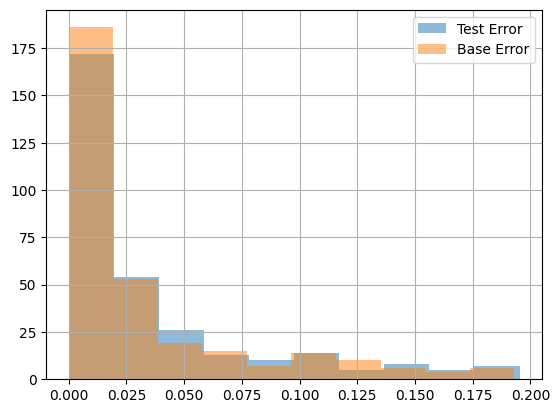

In [28]:
errors = pd.read_csv('growing_window.csv')
test_error = errors['test_error']
test_error = test_error[test_error < 0.2]
test_error.hist(alpha=0.5)

base_error = errors['base_error']
base_error = base_error[base_error < 0.2]
base_error.hist(alpha=0.5)

plt.legend(['Test Error', 'Base Error'])

In [30]:
# Let's try the seasonal tuning now

output_file = 'seasonal_test.csv'

for quarter in range(1, 5):
    train_cols = [(y, quarter) for y in range(2020, 2024)]
    
    test_col = (2024, quarter)
    print(train_cols, test_col)
    i = 0
    
    for oftic in tqdm(list(ibes_data.keys())):
        try:
            eta = optimize_eta(oftic, train_cols, quarterly_actual, quarterly_data)
            test_error = evaluate_eta_test(eta, oftic, [test_col], quarterly_actual, quarterly_data)
            base_error = evaluate_eta_test(0, oftic, [test_col], quarterly_actual, quarterly_data)
            
            df = pd.DataFrame({'ticker': [oftic],
                                'year': [2024],
                                'quarter': [quarter],
                                'eta': [eta],
                                'test_error': [test_error],
                                'base_error': [base_error]})
            if i == 0:
                # Write header only for the first row
                df.to_csv(output_file, mode='w', index=False)
            else:
                # Append to the file without writing the header
                df.to_csv(output_file, mode='a', index=False, header=False)
            i += 1
        except Exception as e:
            print(f"Error for {oftic}: {e}")

[(2020, 1), (2021, 1), (2022, 1), (2023, 1)] (2024, 1)


100%|██████████| 497/497 [41:44<00:00,  5.04s/it]


[(2020, 2), (2021, 2), (2022, 2), (2023, 2)] (2024, 2)


 13%|█▎        | 63/497 [07:26<52:07,  7.21s/it]  

Error for PFE: No neighbors found for ('PFE', 2024, 2)


 26%|██▌       | 130/497 [15:18<22:25,  3.67s/it]  

Error for CI: No neighbors found for ('CI', 2024, 2)


 28%|██▊       | 139/497 [16:17<47:40,  7.99s/it]

Error for ZTS: No neighbors found for ('ZTS', 2024, 2)


 33%|███▎      | 166/497 [19:00<52:51,  9.58s/it]

Error for OKE: No neighbors found for ('OKE', 2024, 2)


 36%|███▋      | 181/497 [20:48<34:42,  6.59s/it]

Error for JCI: No neighbors found for ('JCI', 2024, 2)


 48%|████▊     | 238/497 [27:44<39:15,  9.09s/it]

Error for VRSK: No neighbors found for ('VRSK', 2024, 2)


 87%|████████▋ | 433/497 [54:18<09:21,  8.77s/it]

Error for EVRG: No neighbors found for ('EVRG', 2024, 2)


 90%|████████▉ | 445/497 [55:54<06:24,  7.40s/it]

Error for HST: No neighbors found for ('HST', 2024, 2)


 90%|████████▉ | 446/497 [56:05<07:09,  8.43s/it]

Error for JKHY: No neighbors found for ('JKHY', 2024, 2)


100%|██████████| 497/497 [1:02:27<00:00,  7.54s/it]


[(2020, 3), (2021, 3), (2022, 3), (2023, 3)] (2024, 3)


 45%|████▌     | 226/497 [21:50<17:52,  3.96s/it] 

Error for STZ: No neighbors found for ('STZ', 2024, 3)


 64%|██████▍   | 320/497 [32:07<14:29,  4.91s/it]

Error for VLTO: No neighbors found for ('VLTO', 2024, 3)


 68%|██████▊   | 338/497 [33:55<14:51,  5.61s/it]

Error for HUBB: No neighbors found for ('HUBB', 2024, 3)


 78%|███████▊  | 390/497 [39:42<08:48,  4.94s/it]

Error for PFG: No neighbors found for ('PFG', 2024, 3)


 83%|████████▎ | 413/497 [42:21<10:12,  7.29s/it]

Error for IEX: No neighbors found for ('IEX', 2024, 3)


 94%|█████████▍| 469/497 [48:22<03:10,  6.80s/it]

Error for MGM: No neighbors found for ('MGM', 2024, 3)


 99%|█████████▉| 492/497 [51:00<00:27,  5.42s/it]

Error for CE: No neighbors found for ('CE', 2024, 3)


100%|██████████| 497/497 [51:25<00:00,  6.21s/it]


[(2020, 4), (2021, 4), (2022, 4), (2023, 4)] (2024, 4)


  5%|▌         | 26/497 [02:26<42:47,  5.45s/it] 

Error for ABBV: No neighbors found for ('ABBV', 2024, 4)


  9%|▉         | 47/497 [04:35<50:28,  6.73s/it]

Error for PM: No neighbors found for ('PM', 2024, 4)


 14%|█▍        | 69/497 [06:39<42:09,  5.91s/it]

Error for PGR: No neighbors found for ('PGR', 2024, 4)


 21%|██        | 102/497 [09:53<44:39,  6.78s/it]

Error for MO: No neighbors found for ('MO', 2024, 4)


 38%|███▊      | 189/497 [17:31<19:20,  3.77s/it]

Error for MNST: No neighbors found for ('MNST', 2024, 4)


 51%|█████▏    | 255/497 [24:25<25:56,  6.43s/it]

Error for IQV: No neighbors found for ('IQV', 2024, 4)


 66%|██████▋   | 330/497 [32:16<13:20,  4.79s/it]

Error for CPAY: No neighbors found for ('CPAY', 2024, 4)


 91%|█████████ | 450/497 [45:07<06:42,  8.57s/it]

Error for CHRW: No neighbors found for ('CHRW', 2024, 4)


 93%|█████████▎| 461/497 [46:04<02:17,  3.82s/it]

Error for SOLV: No neighbors found for ('SOLV', 2024, 4)


 96%|█████████▌| 477/497 [47:46<02:05,  6.28s/it]

Error for GNRC: No neighbors found for ('GNRC', 2024, 4)


100%|██████████| 497/497 [49:48<00:00,  6.01s/it]


In [37]:
import math
from functools import reduce

def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)

def lcm_list(numbers):
    return reduce(lcm, numbers)

# Example usage
numbers = [12, 18, 24]
result = lcm_list(numbers)
print(f"The LCM of {numbers} is {result}")

The LCM of [12, 18, 24] is 72


In [34]:
num_samples = [quarterly_data[t, 2024, 1].shape[0] for t in ibes_data.keys() if quarterly_data.get((t, 2024, 1)) is not None]

In [42]:
lcm_list(num_samples)

164249358725037825439200

In [43]:
math.log2(lcm_list(num_samples))

77.12023392028715

In [32]:
quarterly_data['AAPL', 2024, 1].shape

(29, 2)